In [154]:
def f(x):
    return x * 3  + x **2

In [155]:
f(8)

88

In [156]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [157]:
h = 0.0001
x = 3
(f(x+h) - f(x))/h

9.000100000022826

In [158]:
a = 2
b = -3
c = 10.0


d = a*b + c
print(d)

4.0


In [159]:
h = 0.0001
d1 = a*b + c
b +=h
d2 = a*b + c


print('slope', (d2 -d1)/h)

# All correct for now.

slope 2.0000000000042206


In [160]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other),'+')
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad # Havn't understood this part yet ???
        out._backward = _backward

        return out

    

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')


        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward


        return out
    
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(7.0, label = 'c')
d = a * b; d.label = 'd'
e = c * d; e.label = 'e'
e


Value(data=-42.0)

In [161]:
b.grad = 2.0

In [162]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [163]:
from graphviz import Digraph






Right now we can do multiplicaton and addition, but not much else yet.

Now we will learn to calculate the derivatives. 30:50

In [164]:
def lol():

    hbig = Value(10000)
    hsmall = Value(0.0001)

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(6.0, label = 'c')
    d = Value(-9, label= 'e')
    e1 = a*b*c + d
    m = Value(-1)

    enormal = e1 * m; enormal.label = 'enormal'

    a = Value(2.0, label = 'a') 
    b = Value(-3.0, label = 'b')
    c = Value(6.0 + 0.0001, label = 'c')
    d = Value(-9, label= 'e')
    e2 = a*b*c + d
    
    
    
    r = (e2 + enormal) * hbig

    print(r)


    #Worked I did backpropagation correctly in this small model, the derivative -3.00000000 is correct.

In [165]:
lol()

Value(data=-5.9999999999860165)


In [166]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [167]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(7.0, label = 'c')
d = a * b; d.label = 'd'
e = c * d; e.label = 'e'

In [168]:
def lol2():

    h = 0.001

    a = Value(2.0,  label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(7.0+h,  label = 'c')
    d = a * b;  d.label = 'd'
    e = c * d;  e.label = 'e'

    e1 = e.data


    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(7.0, label = 'c')
    d = a * b; d.label = 'd'
    e = c * d; e.label = 'e'

    e2 = e.data
    
    
    
    r = (e1 - e2)/h

    print(r)

In [169]:
lol2()

-6.000000000000227


In [170]:
e.grad = 1

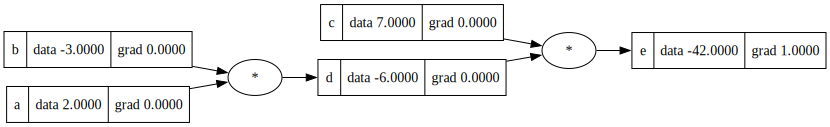

In [171]:
draw_dot(e)

45 minuetse

In [172]:
a.grad = -21
b.grad = 14
c.grad = -6
d.grad = 7
e.grad = 1

In [173]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad


d = a * b;  d.label = 'd'
e = c * d;  e.label = 'e'


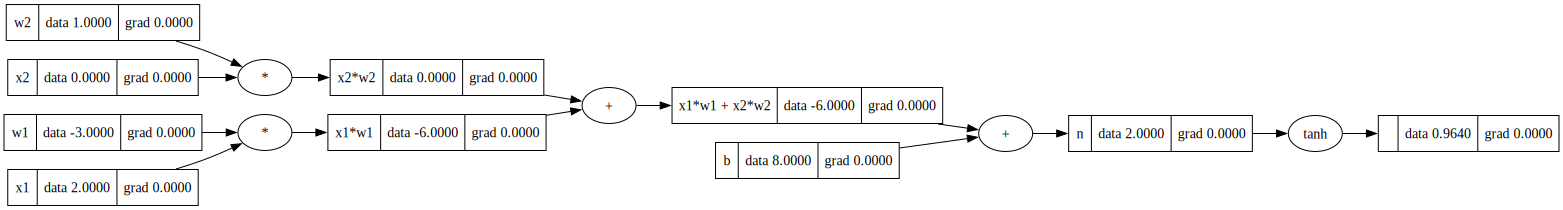

In [174]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(8, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh()

draw_dot(o)

In [175]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

Finished with all that stuff now will use Pytorch

In [176]:
import torch

In [177]:

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [178]:
torch.Tensor([[1,2,3],[4,5,6],[1,2,3],[9,0,0]])

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [1., 2., 3.],
        [9., 0., 0.]])

In [179]:
x1.grad




tensor([-1.5000], dtype=torch.float64)

In [180]:
x2.grad.item()

0.5000001283844369

In [182]:
class Neuron:

    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, X):
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out
    

class MLP:

    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        x = layer(x)
        return x


x = [2.0,5.0]

n = MLP(3,[4,4,1])

n(x)
    

NameError: name 'Layer' is not defined